# Burgers2D_DD_model
Demonstrate the domain decomposition formulation applied to the 2D Burgers equation.  
$\newcommand{\pdx}{\frac{\partial}{\partial x}}$
$\newcommand{\pdxx}{\frac{\partial^2}{\partial x^2}}$
$\newcommand{\pdy}{\frac{\partial}{\partial y}}$
$\newcommand{\pdyy}{\frac{\partial^2}{\partial y^2}}$
$\newcommand{\bb}{\boldsymbol{b}}$
$\newcommand{\br}{\boldsymbol{r}}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bw}{\boldsymbol{w}}$
$\newcommand{\bff}{\boldsymbol{f}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\bv}{\boldsymbol{v}}$
$\newcommand{\bB}{\boldsymbol{B}}$
$\newcommand{\bC}{\boldsymbol{C}}$
$\newcommand{\bI}{\boldsymbol{I}}$
$\newcommand{\bP}{\boldsymbol{P}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\tbB}{\widetilde{\boldsymbol{B}}}$
$\newcommand{\tbC}{\widetilde{\boldsymbol{C}}}$
$\newcommand{\cD}{\mathcal{D}}$
$\newcommand{\real}{\mathbb{R}}$
$\newcommand{\bzero}{\boldsymbol{0}}$
$\newcommand{\set}[1]{\left\{#1\right\}}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_model, subdomain_indices
import scipy.sparse as sp
from utils.newton_solve import newton_solve
from time import time
import os

In [3]:
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 10

## 2D Burgers Equation
The 2D steady-state viscous Burgers Equation on $\Omega = [a, b] \times [c, d]\subset \real^2$ with viscosity $\nu>0$ and inhomogeneous Dirichlet boundary conditions is given by
\begin{align*}
    u \pdx u + v \pdy u &= \nu \left(\pdxx u + \pdyy u\right), \qquad (x, y)\in\Omega, \\
    u \pdx v + v \pdy v &= \nu \left(\pdxx v + \pdyy v\right), \qquad (x, y)\in\Omega,\\
    u(x, y) &= u_D(x, y), \qquad (x, y) \in \partial \Omega, \\
    v(x, y) &= v_D(x, y), \qquad (x, y) \in \partial \Omega. \\
\end{align*}
The domain is discretized uniformly with $n_x+2$ grid points in the $x$-direction and $n_y+2$ grid points in the $y$-direction, resulting in grid points $(x_i, y_j)$ where 
\begin{align*}
x_i = a + i h_x, \qquad i = 0, \dots, n_x+1, \\
y_j = c + j h_y, \qquad j = 0, \dots, n_y+1,
\end{align*}
where $h_x = (b-a)/(n_x+1)$ and $h_y = (d-c)/(n_y+1)$.
The solutions $u, v$ on the grid points are denoted $u_{ij} \approx u(x_i, y_j)$ and $v_{ij} \approx v(x_i, y_j)$. 
The PDE is then discretized using centered finite differences for the first and second derivative terms. The fully discretized system is given by
\begin{align*}
\bff_u(\bu, \bv) &= \bzero, \\
\bff_v(\bu, \bv) &= \bzero,
\end{align*}
where
\begin{align*}
\bu &=
\begin{bmatrix}
\bu^{[1]} \\ \vdots \\ \bu^{[n_y]}
\end{bmatrix} \in \real^{n_xn_y}, \qquad 
\bu^{[j]} = 
\begin{bmatrix}
u_{1, j} \\ \vdots \\ u_{n_x, j}
\end{bmatrix} \in \real^{n_x}, \quad j = 1, \dots, n_y,\\
\bv &=
\begin{bmatrix}
\bv^{[1]} \\ \vdots \\ \bv^{[n_y]}
\end{bmatrix} \in \real^{n_xn_y}, \qquad 
\bv^{[j]} = 
\begin{bmatrix}
v_{1, j} \\ \vdots \\ v_{n_x, j}
\end{bmatrix}\in \real^{n_x}, \quad j = 1, \dots, n_y,\\
 \bff_u(\bu, \bv)&= \bu \odot(\bB_x \bu - \bb_{ux1}) + \bv \odot(\bB_y \bu - \bb_{uy1}) \\
 &\quad + \bC_x \bu + \bb_{ux2} + \bC_y \bu + \bb_{uy2}, \\
  \bff_v(\bu, \bv)&= \bu \odot(\bB_x \bv - \bb_{vx1}) + \bv \odot(\bB_y \bv - \bb_{vy1}) \\
 &\quad + \bC_x \bv + \bb_{vx2} + \bC_y \bv + \bb_{vy2}, \\
\end{align*}
and where 
\begin{align*}
\bB_x &= -\frac{1}{2h_x} \left(\bI_{n_y} \otimes \tbB_x\right)\in \real^{n_xn_y \times n_x n_y}, \qquad
\tbB_x = 
\begin{bmatrix}
0 & 1 \\
-1 & \ddots & 1 \\
& -1 & 0
\end{bmatrix} \in \real^{n_x \times n_x}, \\
\bB_y &= -\frac{1}{2h_y}\left(\tbB_y \otimes \bI_{n_x}\right) \in \real^{n_xn_y \times n_x n_y} \qquad
\tbB_y = 
\begin{bmatrix}
0 & 1 \\
-1 & \ddots & 1 \\
& -1 & 0
\end{bmatrix} \in \real^{n_y \times n_y}, \\
\bC_x &= \frac{\nu}{h_x^2}\left(\bI_{n_y} \otimes \tbC_x\right) \in \real^{n_xn_y \times n_x n_y}, \qquad
\tbC_x = 
\begin{bmatrix}
-2 & 1 \\
1 & \ddots \\
& 1 & -2 \\
\end{bmatrix} \in \real^{n_x \times n_x}, \\
\bC_y &= \frac{\nu}{h_y^2} \left(\tbC_y \otimes \bI_{n_x}\right) \in \real^{n_xn_y \times n_x n_y}, \qquad
\tbC_y =
\begin{bmatrix}
-2 & 1 \\
1 & \ddots \\
& 1 & -2 \\
\end{bmatrix} \in \real^{n_y \times n_y}, \\
\bb_{ux1} &= -\frac{1}{2h_x} (\bb_{ux\ell} - \bb_{uxr}), \qquad
\bb_{uy1} = -\frac{1}{2h_y}(\bb_{uy\ell} - \bb_{uyr}), \\
\bb_{ux2} &= \frac{\nu}{h_x^2}(\bb_{ux\ell} + \bb_{uxr}), \qquad
\bb_{uy2} = \frac{\nu}{h_y^2} (\bb_{uy\ell} + \bb_{uyr}), \\
\bb_{vx1} &= -\frac{1}{2h_x} (\bb_{vx\ell} - \bb_{vxr}), \qquad
\bb_{vy1} = -\frac{1}{2h_y}(\bb_{vy\ell} - \bb_{vyr}), \\
\bb_{vx2} &= \frac{\nu}{h_x^2}(\bb_{vx\ell} + \bb_{vxr}), \qquad
\bb_{vy2} = \frac{\nu}{h_y^2} (\bb_{vy\ell} + \bb_{vyr}), \\
\bb_{ux\ell} &= 
\begin{bmatrix}
u_D(x_0, y_1) \\ \vdots \\ u_D(x_0, y_{n_y})
\end{bmatrix} \otimes 
\begin{bmatrix}
1 \\ 0 \\ \vdots \\ 0
\end{bmatrix}_{n_x \times 1} \in \real^{n_x n_y}, \qquad
\bb_{uxr} = 
\begin{bmatrix}
u_D(x_{n_x+1}, y_1) \\ \vdots \\ u_D(x_{n_x+1}, y_{n_y})
\end{bmatrix} \otimes 
\begin{bmatrix}
0 \\ \vdots \\ 0 \\ 1
\end{bmatrix}_{n_x \times 1} \in \real^{n_x n_y}, \\
\bb_{uyb} &= 
\begin{bmatrix}
1 \\ 0 \\ \vdots \\ 0
\end{bmatrix}_{n_y \times 1} 
\otimes 
\begin{bmatrix}
u_D(x_1, y_0) \\ \vdots \\ u_D(x_{n_x}, y_0)
\end{bmatrix} \in \real^{n_x n_y} \qquad
\bb_{uyt} = 
\begin{bmatrix}
0 \\ \vdots \\ 0 \\ 1
\end{bmatrix}_{n_y \times 1} 
\otimes 
\begin{bmatrix}
u_D(x_1, y_{n_y+1}) \\ \vdots \\ u_D(x_{n_x}, y_{n_y+1})
\end{bmatrix} \in \real^{n_x n_y} \\
\bb_{vx\ell} &= 
\begin{bmatrix}
v_D(x_0, y_1) \\ \vdots \\ v_D(x_0, y_{n_y})
\end{bmatrix} \otimes 
\begin{bmatrix}
1 \\ 0 \\ \vdots \\ 0
\end{bmatrix}_{n_x \times 1} \in \real^{n_x n_y}, \qquad
\bb_{vxr} = 
\begin{bmatrix}
v_D(x_{n_x+1}, y_1) \\ \vdots \\ v_D(x_{n_x+1}, y_{n_y})
\end{bmatrix} \otimes 
\begin{bmatrix}
0 \\ \vdots \\ 0 \\ 1
\end{bmatrix}_{n_x \times 1} \in \real^{n_x n_y}, \\
\bb_{vyb} &= 
\begin{bmatrix}
1 \\ 0 \\ \vdots \\ 0
\end{bmatrix}_{n_y \times 1} 
\otimes 
\begin{bmatrix}
v_D(x_1, y_0) \\ \vdots \\ v_D(x_{n_x}, y_0)
\end{bmatrix} \in \real^{n_x n_y} \qquad
\bb_{vyt} = 
\begin{bmatrix}
0 \\ \vdots \\ 0 \\ 1
\end{bmatrix}_{n_y \times 1} 
\otimes 
\begin{bmatrix}
v_D(x_1, y_{n_y+1}) \\ \vdots \\ v_D(x_{n_x}, y_{n_y+1})
\end{bmatrix} \in \real^{n_x n_y} 
\end{align*}

In [13]:
# define constant parameters for PDE
nx, ny = 480, 24
x_lim  = [-1.0, 1.0]
y_lim  = [0.0, 0.05]
a1_lim    = [1.0, 10000.0]
lam_lim   = [5.0, 25.0]
a1 = 1e4
lam = 5.0
viscosity = 1e-1

fig_dir  = f'./figures/nx_{nx}_ny_{ny}_mu_{viscosity}/'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
u, v, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, maxit=20, print_hist=True)

Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      2.430e+05
   1       1.000e+00      5.958e+02
   2       1.000e+00      3.353e-01
   3       1.000e+00      1.017e-03
   4       1.000e+00      3.157e-06
   5       1.000e+00      9.800e-09
Newton solver terminated after 5 iterations with residual 9.8001e-09.


In [14]:
# compute exact u and v on grid
x        = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y        = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y     = np.meshgrid(x, y)
Uex, Vex = u_exact(X, Y), v_exact(X, Y)

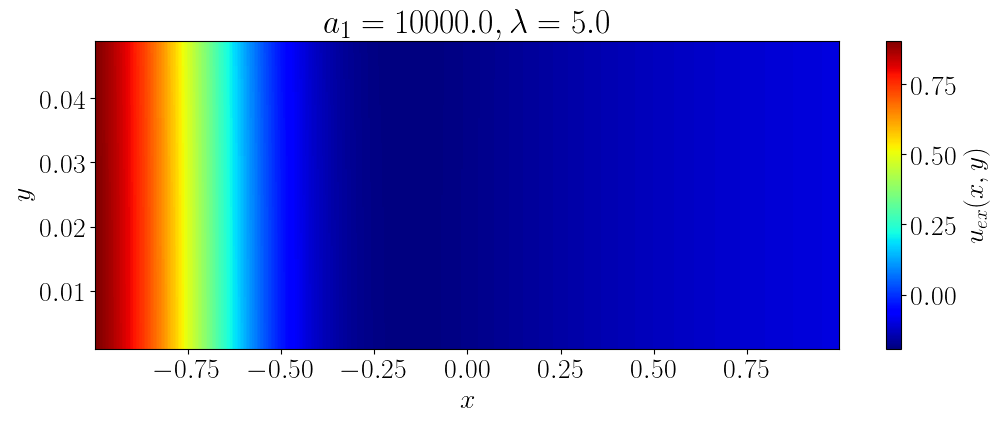

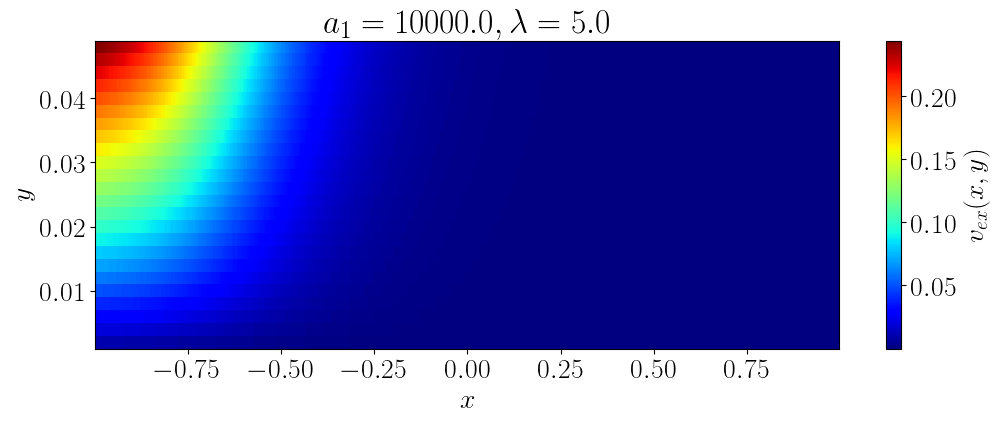

In [15]:
# plot exact u and v
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Uex, cmap=cm.jet, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'$a_1 = {a1}, \lambda = {lam}$')
cb = plt.colorbar(label='$u_{ex}(x, y)$')
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Vex, cmap=cm.jet, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'$a_1 = {a1}, \lambda = {lam}$')
cb = plt.colorbar(label='$v_{ex}(x, y)$')
plt.show()

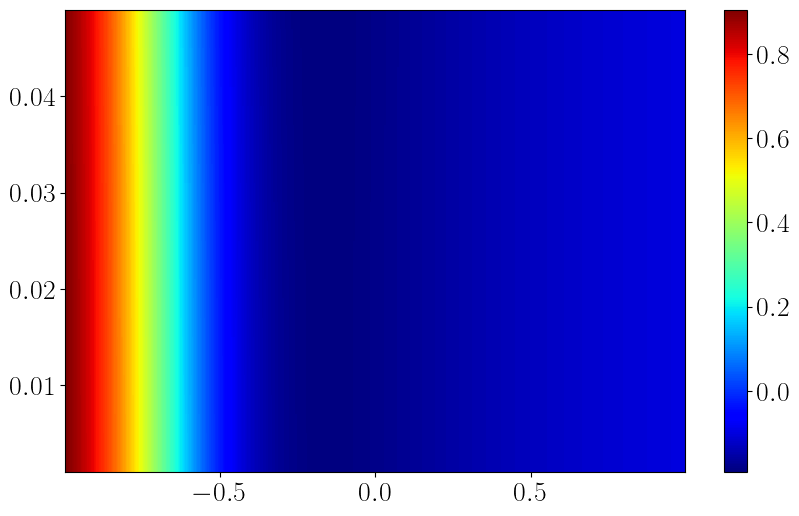

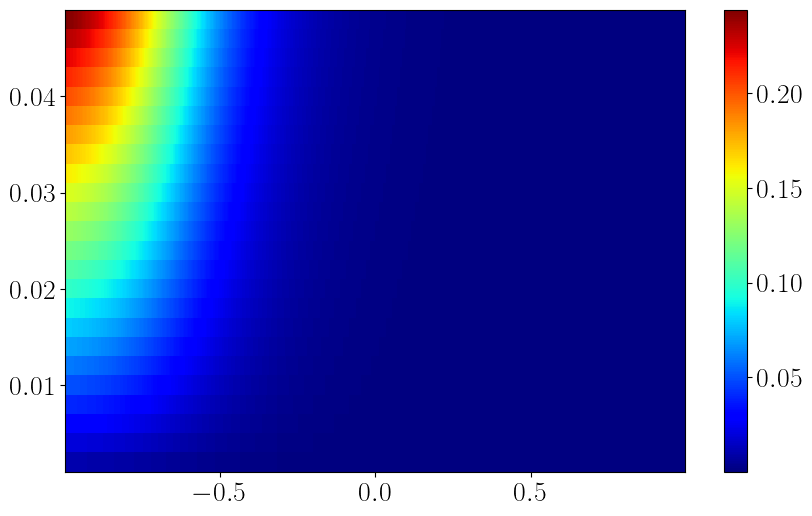

In [16]:
# plot FD u and v
U = u.reshape(ny, nx)
V = v.reshape(ny, nx)

plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Y, U, cmap=cm.jet, shading='auto')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
# plt.title(f'$a_1 = {a1}, \lambda = {lam}$')
file=fig_dir+f'u_fom_a1_{a1}_lam_{lam}.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Y, V, cmap=cm.jet, shading='auto')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
# plt.title(f'$a_1 = {a1}, \lambda = {lam}$')
file=fig_dir+f'v_fom_a1_{a1}_lam_{lam}.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [17]:
# compute relative error between exact and FD solutions
u_rel_err = np.linalg.norm(U-Uex)/np.linalg.norm(Uex)
v_rel_err = np.linalg.norm(V-Vex)/np.linalg.norm(Vex)
print(f'u relative error = {u_rel_err:1.4e}')
print(f'v relative error = {v_rel_err:1.4e}')

u relative error = 2.8161e-07
v relative error = 3.1375e-07


## Domain-decomposition
The full-order model (FOM) can expressed as a parametrized system of nonlinear algebraic equations
\begin{equation}\label{eq:fom_residual}
    \br(\bx; \bmu) = \bzero,
\end{equation}
where $\br: \real^{N_x}\times \cD \to \real^{N_x}$ denotes the residual and is nonlinear in (at least) its first argument, $\bmu \in \cD \subset \real^{N_\mu}$
denotes the FOM parameters, and $\bx:\cD \to \real^{N_x}$ denotes the state.
For notational simplicity, the dependence on $\bmu$ is suppressed until needed.
Next consider a decomposition of the system of the FOM into $n_\Omega \leq N_x$ algebraic subdomains such that the residual satisfies
\begin{equation}\label{eq:fom_dd_residual}
  \br(\bw) = \sum_{i=1}^{n_\Omega} \left(\bP_i^r\right)^T \br_i(\bP_i^\Omega \bw, \bP_i^\Gamma \bw), \qquad \forall \; \bw  \in \real^{N_x},
\end{equation}
where $\br_i: \real^{N_i^\Omega} \times \real^{N_i^\Gamma} \to \real^{N_i^r}$ denotes the residual on the $i$th subdomain,
$\bP_i^r \in \set{0, 1}^{N_i^r \times N_x}$ denotes the $i$th residual sampling matrix,
$\bP_i^\Omega \in \set{0, 1}^{N_i^\Omega \times N_x}$ denotes the $i$th interior-state sampling matrix, and
$\bP_i^\Gamma \in \set{0, 1}^{N_i^\Gamma \times N_x}$ denotes the $i$th interface-state sampling matrix.
The variables 
$$
\bw_i^\Omega := \bP_i^\Omega \bw, \qquad
\bw_i^\Gamma := \bP_i^\Gamma \bw,
$$
are also referred to as the interior and interface states on the $i$th subdomain, respectively. 

Next the domain-decomposition formulation is illustrated on a coarse domain. The subdomain grids are visualized for each subdomain, including each of the interior and interface states and ports.

In [31]:
# define constant parameters for PDE
nx, ny = 8, 8
num_sub_x = 2
num_sub_y = 2

# generate Burgers FOM on coarse grid for visualization
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)

# compute DD model
ddmdl = DD_model(fom, num_sub_x, num_sub_y)

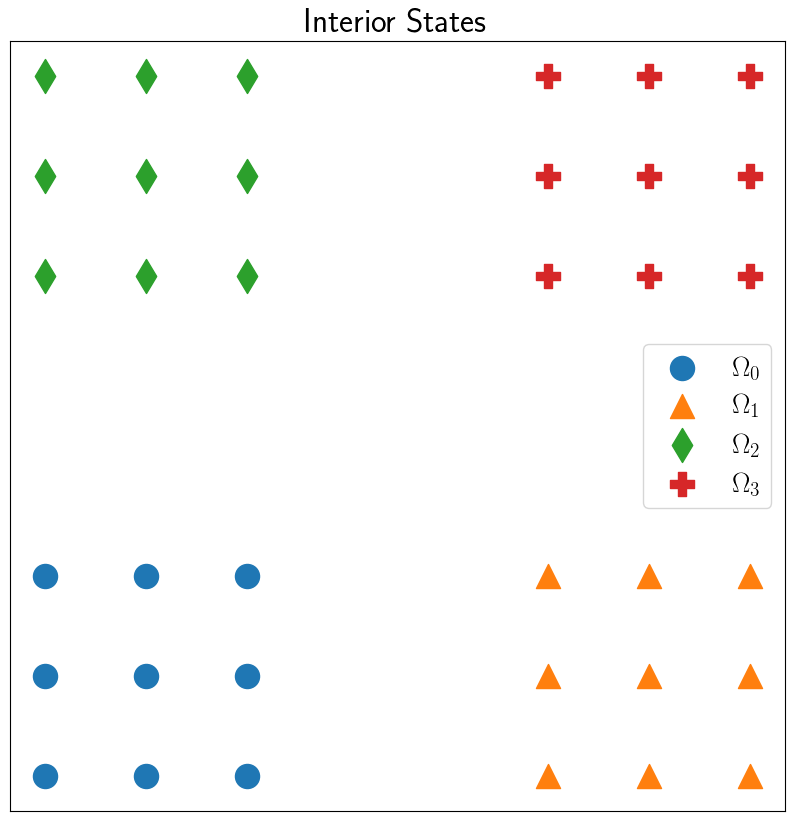

In [32]:
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
xx, yy = X.flatten(), Y.flatten()

# plot interior states
plt.figure(figsize=(10,10))
m = ['o', '^', 'd', 'P', '>', '*']
size = 300
for i, s in enumerate(ddmdl.subdomain):
    plt.scatter(xx[s.interior_ind], yy[s.interior_ind], marker=m[i%5], s=size, label=f'$\Omega_{i}$')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.legend()
plt.title('Interior States')
plt.show()

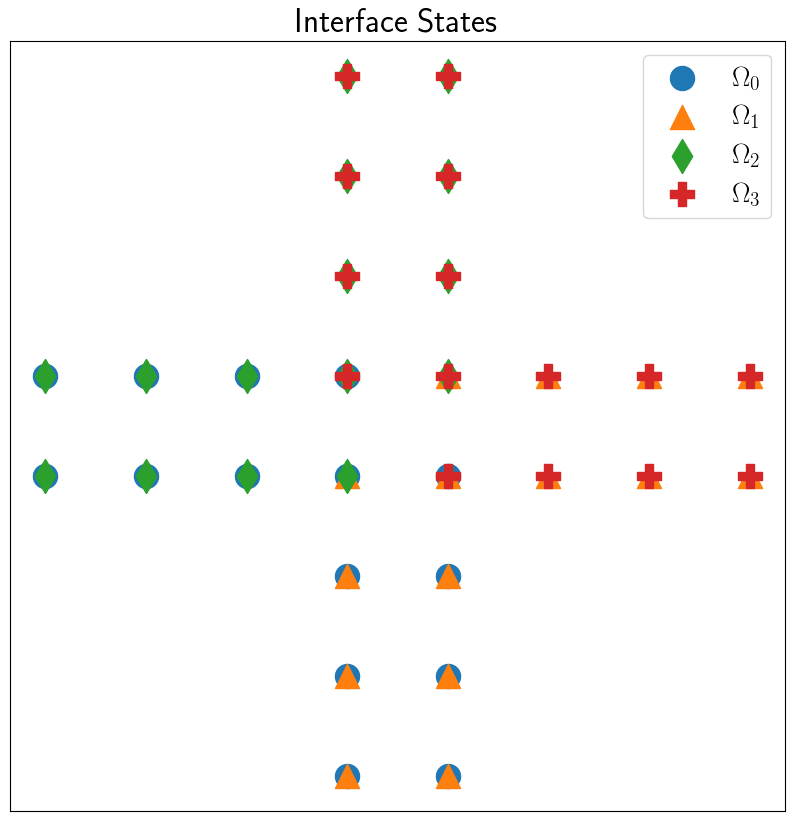

In [33]:
# plot interface states
plt.figure(figsize=(10,10))
for i, s in enumerate(ddmdl.subdomain):
    plt.scatter(xx[s.interface_ind], yy[s.interface_ind], s=size, marker=m[i%5], label=f'$\Omega_{i}$')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.legend()
plt.title('Interface States')
plt.show()

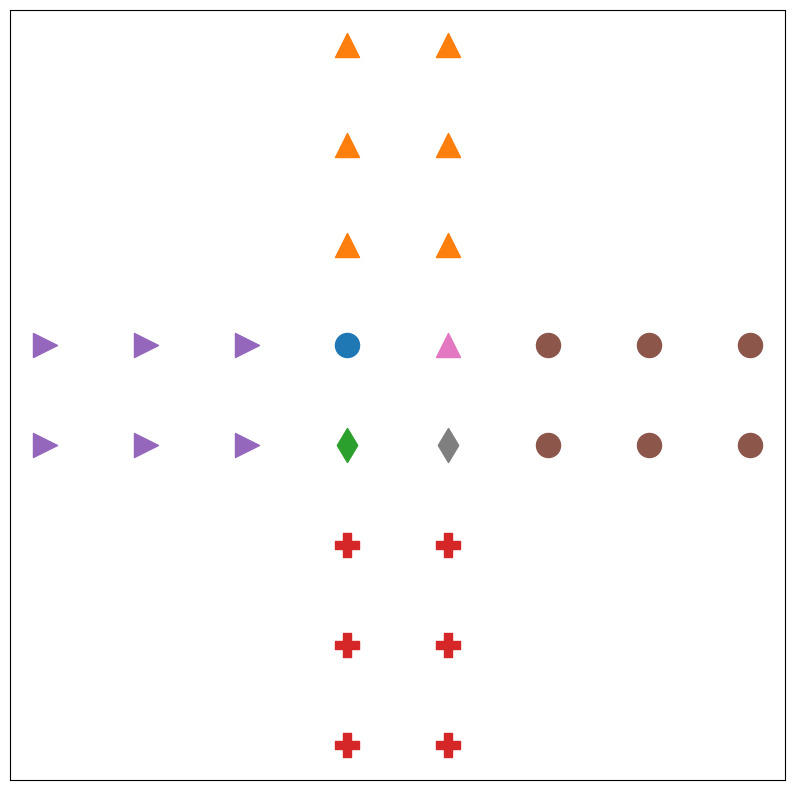

In [34]:
# plot ports
plt.figure(figsize=(10,10))
for i, port in enumerate(ddmdl.ports):
    plt.scatter(xx[ddmdl.port_dict[port]], yy[ddmdl.port_dict[port]], s=size, marker=m[i%5], label=f'{i}') #label=f'{list(port)}')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.legend(ncol=2)
file = './figures/dd_ports.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

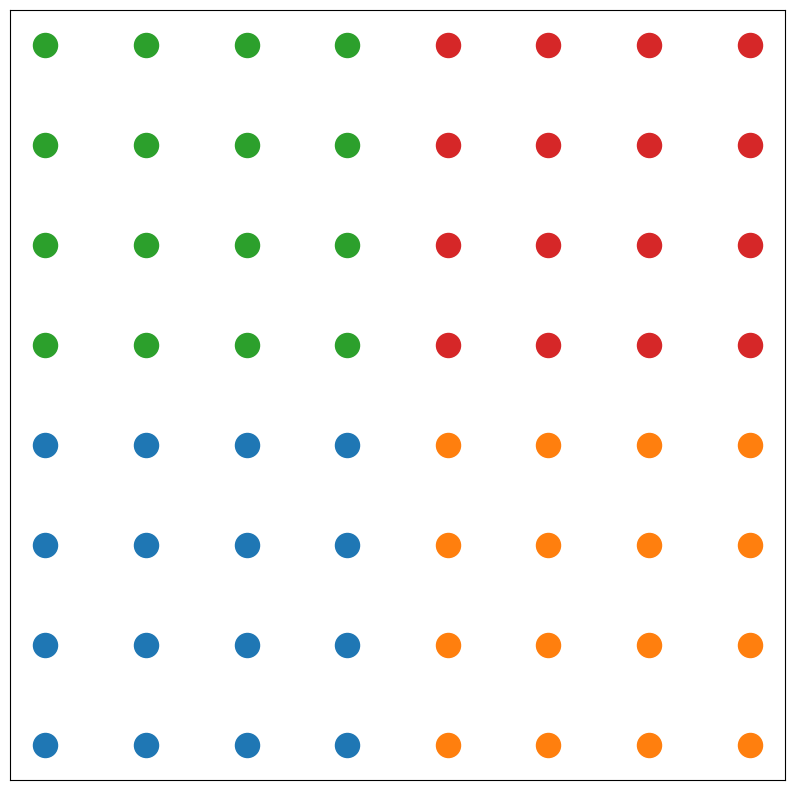

In [40]:
# plot residual indices
plt.figure(figsize=(10,10))
for i, s in enumerate(ddmdl.subdomain):
    plt.scatter(xx[s.residual_ind], yy[s.residual_ind], s=size, marker='o', label=f'$\Omega_{i}$')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
file = './figures/dd_residuals.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

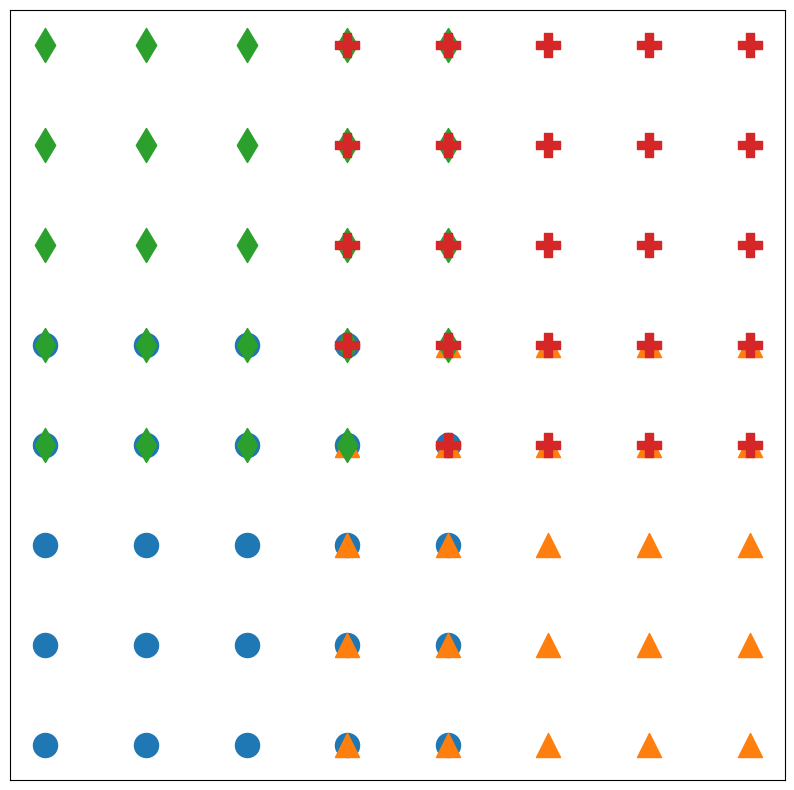

In [43]:
# plot subdomain indices
plt.figure(figsize=(10,10))
colors = ['blue', 'orange', 'green', 'red']
for i, s in enumerate(ddmdl.subdomain):
#     plt.scatter(xx[s.interior_ind], yy[s.interior_ind], s=size, color=colors[i%5], marker='o')
#     plt.scatter(xx[s.interface_ind], yy[s.interface_ind], s=size, color=colors[i%5], marker='P')
    
    xx_i = np.concatenate((xx[s.interior_ind], xx[s.interface_ind]))
    yy_i = np.concatenate((yy[s.interior_ind], yy[s.interface_ind]))
    plt.scatter(xx_i, yy_i, s=size, marker=m[i%5], label=f'$\Omega_{i}$')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.legend()
# plt.title('Subdomain states')
file = './figures/dd_states.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [14]:
# checks that constraint matrices are computed correctly
c = np.zeros(ddmdl.n_constraints)
vec = np.random.rand(2*fom.nxy)
for s in ddmdl.subdomain:
    c += s.constraint_mat@np.concatenate([vec[s.interface_ind],vec[fom.nxy+s.interface_ind]])
print('||sum(A[i] x[i])||=', np.linalg.norm(c))

||sum(A[i] x[i])||= 0.0


# Compute state solutions u and v using DD model

In [15]:
# define constant parameters for PDE
nx, ny = 120, 12
num_sub_x = 2
num_sub_y = 1

# generate Burgers FOM on coarse grid for visualization
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
u, v, res = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-7, print_hist=True)


Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      1.200e+06
   1       1.000e+00      1.218e+05
   2       1.000e+00      9.402e+04
   3       1.000e+00      2.257e+04
   4       1.000e+00      6.862e+03
   5       1.000e+00      1.951e+03
   6       1.000e+00      5.731e+02
   7       1.000e+00      1.689e+02
   8       1.000e+00      5.051e+01
   9       1.000e+00      1.531e+01
  10       1.000e+00      4.711e+00
  11       1.000e+00      1.472e+00
  12       1.000e+00      4.668e-01
  13       1.000e+00      1.500e-01
  14       1.000e+00      4.876e-02
  15       1.000e+00      1.600e-02
  16       1.000e+00      5.289e-03
  17       1.000e+00      1.758e-03
  18       1.000e+00      5.872e-04
  19       1.000e+00      1.967e-04
  20       1.000e+00      6.605e-05
  21       1.000e+00      2.222e-05
  22       1.000e+00      7.482e-06
  23       1.000e+00      2.522e-06
  24       1.000e+00      8.506e-07
  25       1.000e+00      2.870e-07
  2

In [16]:
# compute DD model
ddmdl_s = DD_model(fom, num_sub_x, num_sub_y, constraint_type='stong')

# Solve DD model
ndof_s = 2*np.sum([s.n_interior+s.n_interface for s in ddmdl_s.subdomain]) \
            + ddmdl_s.subdomain[0].constraint_mat.shape[0]
w0_s = np.zeros(ndof_s)
u_s, v_s, u_s_intr, v_s_intr, u_s_intf, v_s_intf, lam_s, strong_time, itr = ddmdl_s.solve(w0_s, tol=1e-5, 
                                                                              maxit=15,
                                                                              print_hist=True)

Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      1.833e+10
   1       1.000e+00      1.205e+09
   2       5.000e-01      7.224e+08
   3       1.000e+00      3.674e+08
   4       1.000e+00      1.123e+08
   5       1.000e+00      3.330e+07
   6       1.000e+00      9.541e+06
   7       1.000e+00      2.783e+06
   8       1.000e+00      8.164e+05
   9       1.000e+00      2.424e+05
  10       1.000e+00      7.292e+04
  11       1.000e+00      2.225e+04
  12       1.000e+00      6.896e+03
  13       1.000e+00      2.170e+03
  14       1.000e+00      6.922e+02
  15       1.000e+00      2.237e+02
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 2.2365e+02.


In [17]:
w0_w = np.array([])
for i in range(ddmdl_s.n_sub):
    w0_w = np.concatenate([w0_w, u_s_intr[i], v_s_intr[i], u_s_intf[i], v_s_intf[i]])

In [18]:
# compute DD model
ddmdl_w = DD_model(fom, num_sub_x, num_sub_y, constraint_type='weak', n_constraints=47)

# Solve DD model
ndof_w = 2*np.sum([s.n_interior+s.n_interface for s in ddmdl_w.subdomain]) \
            + ddmdl_w.subdomain[0].constraint_mat.shape[0]
# w0_w = np.concatenate([w0_w, np.zeros(ddmdl_w.n_constraints)])
w0_w = np.zeros(ndof_w)
u_w, v_w, u_w_intr, v_w_intr, u_w_intf, v_w_intf, lam_w, strong_time, itr = ddmdl_w.solve(w0_w, tol=1e-5, 
                                                                              maxit=15,
                                                                              print_hist=True)

Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      1.833e+10
   1       1.000e+00      1.249e+09
   2       5.000e-01      7.382e+08
   3       1.000e+00      3.668e+08
   4       1.000e+00      1.120e+08
   5       1.000e+00      3.317e+07
   6       1.000e+00      9.489e+06
   7       1.000e+00      2.765e+06
   8       1.000e+00      8.109e+05
   9       1.000e+00      2.408e+05
  10       1.000e+00      7.240e+04
  11       1.000e+00      2.214e+04
  12       1.000e+00      6.863e+03
  13       1.000e+00      2.161e+03
  14       1.000e+00      6.898e+02
  15       1.000e+00      2.230e+02
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 2.2297e+02.


In [19]:
error = 0.0
for j in range(ddmdl_s.n_sub):
    num = np.sum(np.square(u_s_intr[j]-u_w_intr[j])) +\
          np.sum(np.square(v_s_intr[j]-v_w_intr[j])) +\
          np.sum(np.square(u_s_intf[j]-u_w_intf[j])) +\
          np.sum(np.square(v_s_intf[j]-v_w_intf[j]))
    den = np.sum(np.square(u_s_intr[j])) +\
          np.sum(np.square(v_s_intr[j])) +\
          np.sum(np.square(u_s_intf[j])) +\
          np.sum(np.square(v_s_intf[j]))
    error += num#/den
error = np.sqrt(error/ddmdl_s.n_sub)
print(f'Error between solutions to strongly and weakly constrained FOMs = {error:1.4e}')

Error between solutions to strongly and weakly constrained FOMs = 1.0441e+02


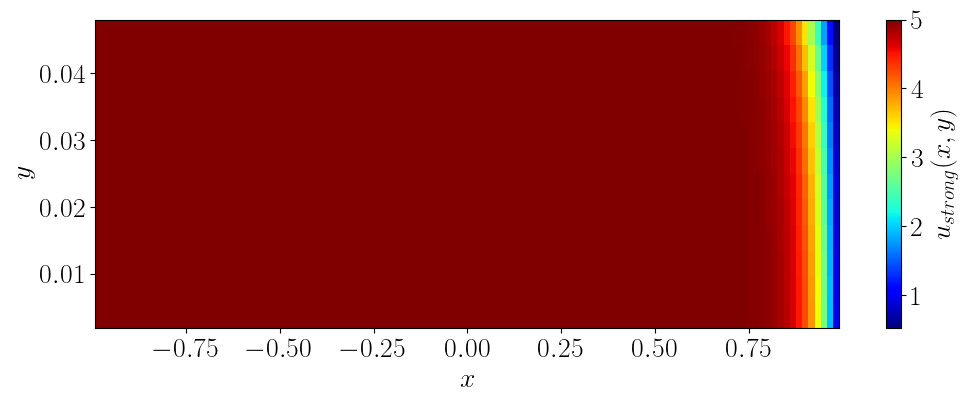

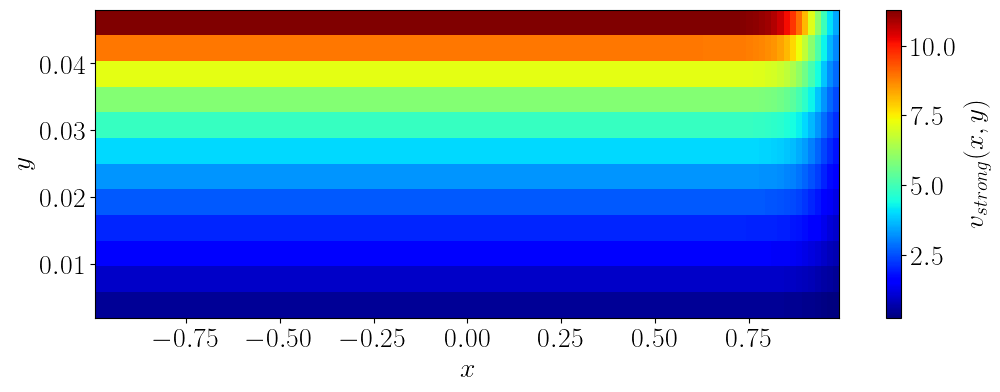

In [20]:
# plot FD u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_full = u_s.reshape(ny, nx)
V_full = v_s.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_full, cmap=cm.jet, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$u_{strong}(x, y)$')

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_full, cmap=cm.jet, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$v_{strong}(x, y)$')

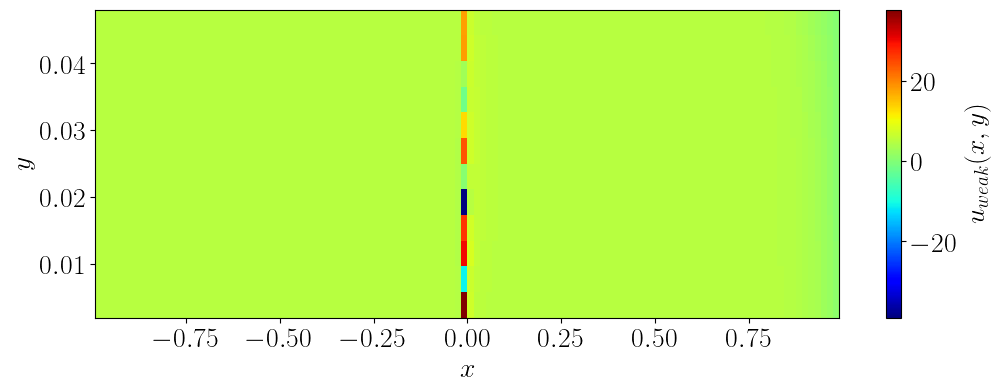

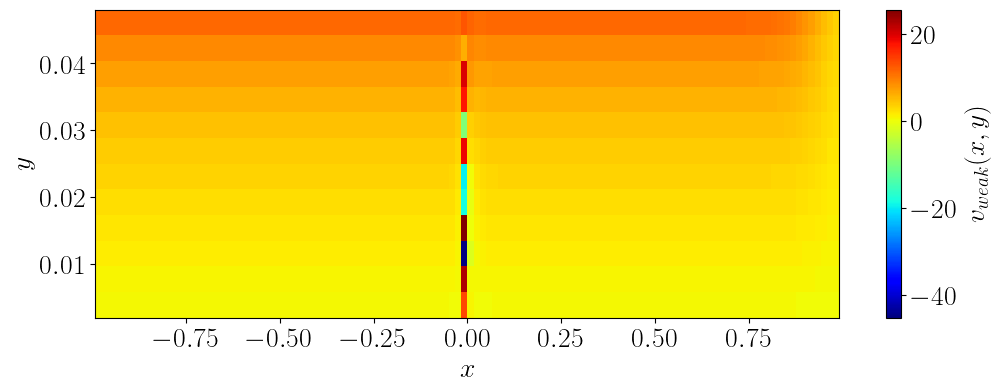

In [21]:
# plot FD u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_full = u_w.reshape(ny, nx)
V_full = v_w.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_full, cmap=cm.jet, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$u_{weak}(x, y)$')

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_full, cmap=cm.jet, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$v_{weak}(x, y)$')

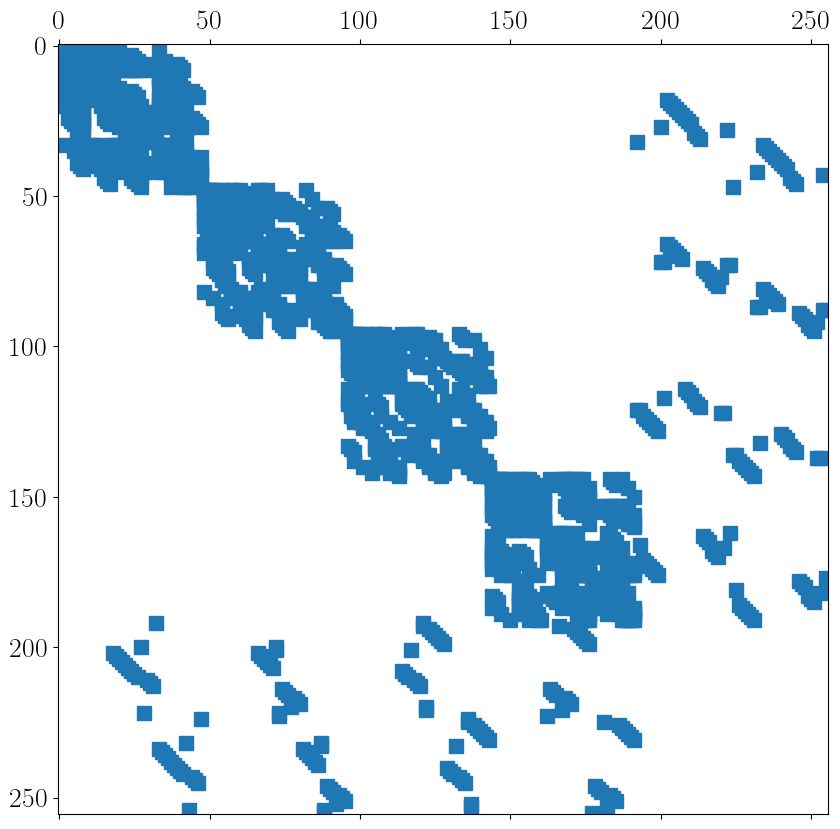

In [22]:
# plot sparsity of jacobian
r, jac = ddmdl.FJac(np.random.rand(ndof_s))
plt.figure(figsize=(10, 10))
plt.spy(jac)
plt.show()

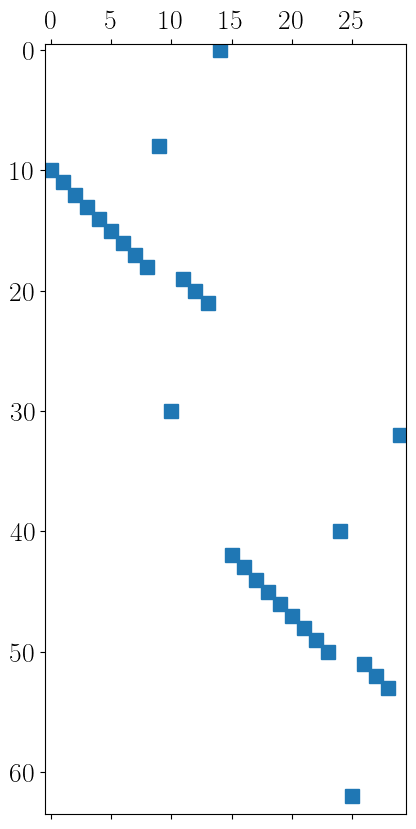

In [23]:
# plot sparsity of constraint matrix
plt.figure(figsize=(10, 10))
plt.spy(ddmdl.subdomain[0].constraint_mat)
plt.show()

In [24]:
dd_u_rel_err = np.linalg.norm(u_s-u)/np.linalg.norm(u)
dd_v_rel_err = np.linalg.norm(v_s-v)/np.linalg.norm(v)
print('DD u relative error = ', dd_u_rel_err)
print('DD v relative error = ', dd_v_rel_err)

DD u relative error =  6.12792827792765e-12
DD v relative error =  1.2773074726276408e-08


In [25]:
len(u_s_intr)

2

In [26]:
ddmdl.n_sub

4